# Emotion regression


Training and evaluating two Support Vector Regression models for prediction of arousal and valence. Using Essentia Music Extractor to compute summarized descriptor values (no frames)
Steps to be followed : 1) Loads the dataset 2) Normalizes all features to [0, 1] or [-1, 1] interval 3) Splits dataset into two subsets 4) Trains model on training subset 5) Predicts arousal/valence for testing subset and evaluates predictions using regression metrics`

# Initialization for the generation of json and building svr


In [1]:
import os
import subprocess
from natsort import natsorted, ns
import json
import string
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, average_precision_score, explained_variance_score, r2_score
from natsort import natsorted, ns
import numpy as np
import matplotlib.pyplot as plt

#declaration of variables for audio,descriptors and annotations
config = 'config.yaml'
indir = 'audio'
outdir = 'descriptors'

#open the audiofiles 
audiofiles = os.listdir(indir)
audiofiles = [f for f in audiofiles if f.endswith('.mp3')]
audiofiles = natsorted(audiofiles, key=lambda y: y.lower())

#check if the path exists
if not os.path.exists(outdir):
    os.makedirs(outdir)

for idx,f in enumerate(audiofiles):
    f = f.split('.')
    filename = f[0]
    extension = f[1]
    if extension == 'mp3':
        infile = '{}.mp3'.format(filename)
        inpath = os.path.join(indir, infile)
        outfile = '{}.json'.format(filename)
        outpath = os.path.join(outdir, outfile)
        if os.path.isfile(outpath):
            print 'Skipping {}'.format(outpath)
        else:
            print 'Generating {}... {}/{}'.format(outpath, idx, len(audiofiles))
            with open(os.devnull, 'w') as devnull:
                p = subprocess.call(["streaming_extractor_music.exe", inpath, outpath, config], stdout=devnull)


Skipping descriptors\2.json
Skipping descriptors\3.json
Skipping descriptors\4.json
Skipping descriptors\5.json
Skipping descriptors\7.json
Skipping descriptors\8.json
Skipping descriptors\10.json
Skipping descriptors\12.json
Skipping descriptors\13.json
Skipping descriptors\17.json
Skipping descriptors\18.json
Skipping descriptors\19.json
Skipping descriptors\20.json
Skipping descriptors\21.json
Skipping descriptors\22.json
Skipping descriptors\24.json
Skipping descriptors\25.json
Skipping descriptors\31.json
Skipping descriptors\32.json
Skipping descriptors\35.json
Skipping descriptors\37.json
Skipping descriptors\39.json
Skipping descriptors\40.json
Skipping descriptors\41.json
Skipping descriptors\42.json
Skipping descriptors\43.json
Skipping descriptors\44.json
Skipping descriptors\45.json
Skipping descriptors\46.json
Skipping descriptors\47.json
Skipping descriptors\48.json
Skipping descriptors\49.json
Skipping descriptors\50.json
Skipping descriptors\51.json
Skipping descriptors

# Part 2

Training and Testing and Evaluation

Steps to be followed : 
1)gather every json generated from the audio files
2)iterate over all the numeric attributes, which are around 1100
3)arrange all of those attributes into a big matrix containg all the descriptors, from all the files
4)divide that into two sets, training and test
5)load the csv and create two arrays from that, one for annotated valence, and another for annotated arousal
6) train two SVR models, using the trainingset from the files and the annotations, one for valence and one for arousal
7)the remaining files, from 1701.mp3 onwards, are used for testing

Evaluation:
1)Mean squared error : The mean_squared_error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error loss or loss.
2)Mean absolute error : The mean_absolute_error function computes mean absolute error, a risk metric corresponding to the expected value of the absolute error loss or l1-norm loss.
3) Explained variance score : 
4)R² score, the coefficient of determination : The r2_score function computes R², the coefficient of determination. It provides a measure of how well future samples are likely to be predicted by the model. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

    

Evaluation
Mean Squared Error: 0.98682031986
Mean Absolute Error: 0.816667995408
Explained Variance Score: 0.00514680655762
R2 Score: -0.000224394073451


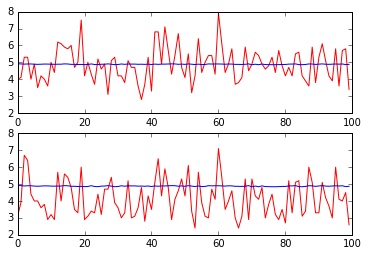

In [3]:
# indir = 'descriptors'
annotationsfile = 'annotations.csv'


#There were few missing files and hence they were removed
missing_at_csv = [
'1029.json',
'1059.json',
'1064.json',
'1255.json',
'1297.json',
'1320.json',
'1614.json',
'1654.json',
'1968.json'
]

#gather every json generated from the audio files iterate over all the numeric attributes, which are around 1100
jsonfiles = os.listdir(indir)
jsonfiles = [f for f in jsonfiles if f.endswith('.json') and f not in missing_at_csv]
jsonfiles = natsorted(jsonfiles, key=lambda y: y.lower())

#arrange all of those attributes into a big matrix containg all the descriptors, from all the files divide that into two sets, training and test
trainingset = []
testset = []

valencetraining = []
valenceeval = []
arousaltraining = []
arousaleval = []

 #This function iterates over all the json file and gets the numeric values '''
def walkjson(x, xname, d, indents=0):
    ''' beats_position length varies for each audio file,
        spectral_spread sometimes detected as non-numeric value,
        ignoring both... '''
    if xname == 'beats_position' or xname == 'spectral_spread':
        return
    if isinstance(x, dict):
        #print '{}{}'.format('\t'*indents, xname)
        for k,v in x.iteritems():
            walkjson(v, k, d, indents + 1)
    elif isinstance(x, list):
        #print '{}{}'.format('\t'*indents, xname)
        for idx,l in enumerate(x):
            walkjson(l, idx, d, indents + 1)
    elif isinstance(x, tuple):
        #print '{}tuple'.format('\t'*indents)
        for idx,t in enumerate(x):
            walkjson(t, idx, d, indents + 1)
    else:
        if isinstance(x, float) or isinstance(x, int):
            #print '{}{}'.format('\t'*indents, x)
            d.append(x)
        else:
            ''' NON-NUMERIC '''
            #print 'NON-NUMERIC {}'.format(x)

for filename in jsonfiles:
    with open(os.path.join(indir,filename)) as f:
        data = 	json.load(f)
        descriptors = []
        walkjson(data, filename, descriptors)
        if int(filename[:-5]) < 1701:
            trainingset.append(descriptors)
        else:
            testset.append(descriptors)
        #print '{} - {}'.format(filename, len(descriptors), len(nonnumeric), nonnumeric)

trainingset = np.array(trainingset, dtype=np.float64)
testset = np.array(testset, dtype=np.float64)
trainingset = preprocessing.normalize(trainingset)
testset = preprocessing.normalize(testset)

with open(annotationsfile) as csv:
    lines = csv.readlines()
    for line in lines[1:]:
        annot = line.strip().split(',')
        if int(annot[0]) < 1701:
            valencetraining.append(annot[1])
            arousaltraining.append(annot[2])
        else:
            valenceeval.append(annot[1])
            arousaleval.append(annot[2])


valencetraining = np.array(valencetraining, dtype=np.float64)
arousaltraining = np.array(arousaltraining, dtype=np.float64)
valenceeval = np.array(valenceeval, dtype=np.float64)
arousaleval = np.array(arousaleval, dtype=np.float64)

valsvr = svm.SVR()
valsvr.fit(trainingset, valencetraining)

arosvr = svm.SVR()
arosvr.fit(trainingset, arousaltraining)

valpredict = valsvr.predict(testset)
aropredict = arosvr.predict(testset)

#Evaluation 
mse = mean_squared_error(valenceeval, valpredict)
mae = mean_absolute_error(valenceeval, valpredict)
evs = explained_variance_score(valenceeval, valpredict)
r2 = r2_score(valenceeval, valpredict)
print 'Evaluation'
print "Mean Squared Error: {}\nMean Absolute Error: {}\nExplained Variance Score: {}\nR2 Score: {}".format(mse, mae, evs, r2)

#Plotting first 100 features
plt.subplot(211)
plt.plot(np.arange(0,100), valenceeval[:100], 'r')
plt.subplot(211)
plt.plot(np.arange(0,100), valpredict[:100], 'b')
plt.subplot(212)
plt.plot(np.arange(0,100), arousaleval[:100], 'r')
plt.subplot(212)
plt.plot(np.arange(0,100), aropredict[:100], 'b')
plt.show()
